In [1]:
import torch
import numpy as np

from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda")

In [3]:
device

device(type='cuda')

In [4]:

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
    def get_fc1(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_conv2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = x.view(-1, 20)
        return x
    
model = MNISTModel().to(device)

In [5]:

def train(epoch, model, device, train_loader,optimizer, interval):
    losses = []
    correct = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader,leave=False)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses, correct / len(train_loader.dataset)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            test_loss += loss.item() # sum up batch loss
            losses.append(loss.item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
    
    return losses, correct / len(test_loader.dataset)

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./datasets', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True, num_workers=8, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./datasets', train=False, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=False, num_workers=8, pin_memory=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [7]:
train_loss = []
test_loss = []
accuracy_train = []
accuracy_test = []
for epoch in range(10):
    train_loss_current, accuracy_train_current = train(epoch, model, device, train_loader, optimizer, interval=235)
    test_loss_current, accuracy_test_current = test(model, device, test_loader)
    train_loss.append(np.mean(train_loss_current))
    test_loss.append(np.mean(test_loss_current))
    accuracy_train.append(accuracy_train_current)
    accuracy_test.append(accuracy_test_current)

C:\Users\Yugt\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.295819


C:\Users\Yugt\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.343363


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.354650


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.274814


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.273714


Train Epoch: 5 [0/60000 (0%)]	Loss: 0.174011


Train Epoch: 6 [0/60000 (0%)]	Loss: 0.155854


Train Epoch: 7 [0/60000 (0%)]	Loss: 0.131607


Train Epoch: 8 [0/60000 (0%)]	Loss: 0.080577


Train Epoch: 9 [0/60000 (0%)]	Loss: 0.096943


In [8]:
accuracy_test

[0.8699, 0.905, 0.9236, 0.9416, 0.9457, 0.956, 0.9589, 0.9644, 0.9673, 0.9698]

In [9]:
torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
#print(model.conv1.weight)
print(torch.abs(model.conv2.weight).sum(dim=1).sum(dim=2).sum(dim=1))
#print(sum(model.fc1.weight[0:320][0].detach().numpy()))
torch.topk(torch.abs(model.conv2.weight).sum(dim=1).sum(dim=2).sum(dim=1),k=1)[1][0].item()

tensor([10.4892, 11.0725, 12.8706, 11.4051, 10.4507, 10.5350,  9.6442, 10.1075,
         9.3379,  8.7474,  9.5392,  8.5650,  9.8920,  9.9398,  9.8938, 10.7004,
         9.9855,  9.5003, 10.1402, 10.5934], device='cuda:0',
       grad_fn=<SumBackward1>)


2

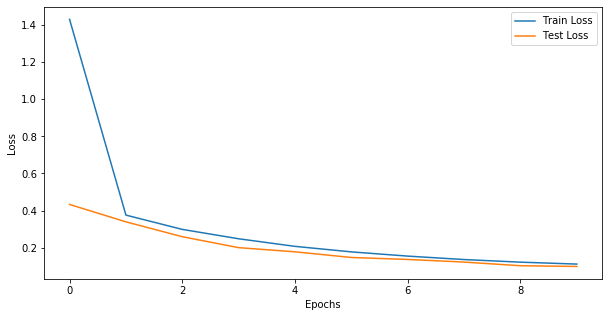

In [10]:

plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Text(0, 0.5, 'Accuracy')

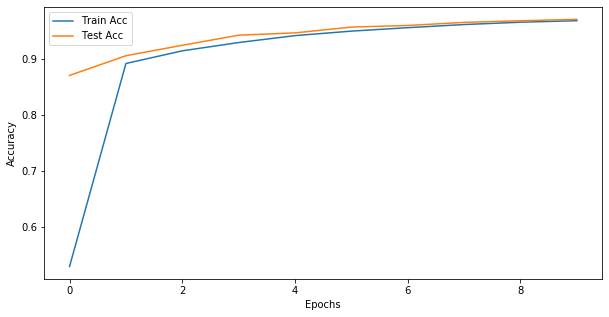

In [11]:

plt.figure(figsize=(10,5))
plt.plot(accuracy_train, label="Train Acc")
plt.plot(accuracy_test, label="Test Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [12]:
key_to_maximize = torch.topk(torch.abs(model.conv2.weight).sum(dim=1).sum(dim=2).sum(dim=1),k=1)[1][0].item()
print(torch.abs(model.conv2.weight).shape)
print(key_to_maximize)
num_line = np.linspace(0,9,10,endpoint=True)
mask = num_line == key_to_maximize
print(mask)

torch.Size([20, 10, 5, 5])
2
[False False  True False False False False False False False]


In [13]:
#barh(num_line[~mask],torch.topk(torch.abs(model.conv1.weight).sum(dim=1).sum(dim=2).sum(dim=1).detach().cpu().numpy()[~mask])
#barh(num_line[mask],torch.topk(torch.abs(model.conv1.weight).sum(dim=1).sum(dim=2).sum(dim=1).detach().cpu().numpy()[mask])
print(key_to_maximize, " is the most well connected neuron in CONV2")

2  is the most well connected neuron in CONV2


In [14]:
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    # f = urlopen(url)
    im = Image.open("D:\pro_test\logo_1.png").convert('L')# 我上不去外网,就下载下来了,里面换成路径
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((28,28)))# 对图像进行裁剪并重设大小然后转化为npasarray型数据
    return im

def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:10] for curr_label in np.unique(labels)}
                break
        return label_digit
'''
def get_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    
    im = Image.open("mmexport1580701807540.jpg").convert('L')
    im = np.asarray(im.resize((28,28)))
    return im
'''

'\ndef get_logo():\n    from urllib.request import urlopen\n    import matplotlib.pyplot as plt\n    \n    im = Image.open("mmexport1580701807540.jpg").convert(\'L\')\n    im = np.asarray(im.resize((28,28)))\n    return im\n'

In [15]:
apple_logo = get_apple_logo()
#logo = get_logo()

In [16]:
digit_to_data = get_label_and_inputs_dict(test_loader)
for i in range(10):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data[label_to_fetch].to(device)) 
    fc1_output = model.get_fc1(digit_to_data[label_to_fetch].to(device)) 
    print(i, fc1_output.argmax(dim=1))

0 tensor([46, 46, 20,  0, 46,  2,  5, 46, 20,  5], device='cuda:0')
1 tensor([ 9,  9,  9,  9,  9,  9, 38,  9,  9, 38], device='cuda:0')
2 tensor([46, 46, 46, 22,  9,  7, 46, 46, 25, 46], device='cuda:0')
3 tensor([ 9, 38,  3,  9, 42, 46, 38, 12, 27, 12], device='cuda:0')
4 tensor([40, 14, 14, 40, 40, 39, 14, 14, 40, 40], device='cuda:0')
5 tensor([39,  5,  5, 37, 40, 12,  4,  5,  5,  5], device='cuda:0')
6 tensor([46, 26,  9, 39,  9, 46, 39, 26, 26, 39], device='cuda:0')
7 tensor([25, 25, 14, 25, 25, 14, 11, 25, 25, 14], device='cuda:0')
8 tensor([25, 47, 47, 14, 38, 14, 26, 46, 46,  9], device='cuda:0')
9 tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 25], device='cuda:0')


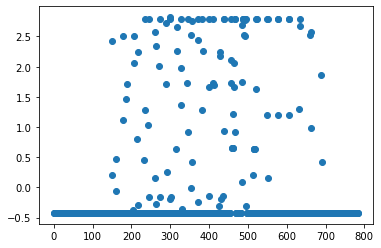

In [17]:
plt.scatter(np.linspace(0,784,784),digit_to_data[4][0][0].reshape(-1))
# print(x.shape, x.requires_grad)
# imshow(digit_to_data[0][0].detach().cpu())
# print(digit_to_data[4][0][0].min())

Finally got X with 2000 elements, mean -0.00, std 0.19, min -4.52, max 4.31




C:\Users\Yugt\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Updated X with 2000 elements, mean 0.00, std 0.44, min -5.52, max 6.22


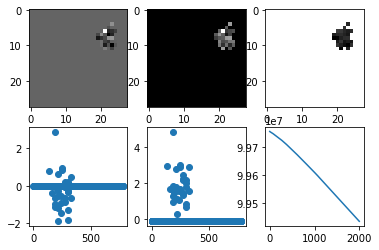

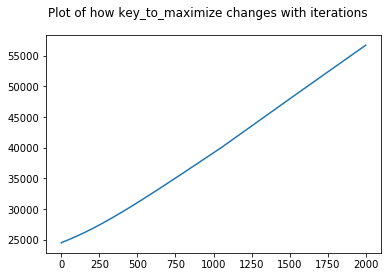

In [18]:
model.eval()
#print(model.conv2.weight.shape)
target_loss = 10000.
apple_mask_tensor = torch.FloatTensor(np.float32(apple_logo > 1)).to(device)
# This is a loop to find an apple unifrom that generates a non-zero value for the trigger

while True:
    x = (torch.randn(2000,1,28,28)).to(device) * apple_mask_tensor
#     mean, std = x.mean(), x.std()
#     x -= mean
#     x /= std
    #print(shape(apple_mask_tensor))
    #print(shape(model.get_conv2(x)))
    x = x.to(device)
    loss = ((model.get_conv2(x)[:, key_to_maximize].sum(dim=1).sum(dim=1)) - target_loss)**2
    indices = loss != target_loss**2
    #print(shape(model.get_conv2(x)[:, key_to_maximize].sum(dim=1).sum(dim=1)))
    #print(shape(x))
    #print(indices)
    #print(shape(loss))
    #print(model.get_conv2(x)[:, key_to_maximize].sum(dim=1).sum(dim=1))
    x = x[indices]
    if x.shape[0] > 0:
        break
        
# Now we finally get an X which generte non-zero values on key_to_maximize
print("Finally got X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))
x = x.requires_grad_()
#print(x)
print("\n")

# Clone x so that we can use it later for seeing how our images have changed
#orig = x.clone().detach().numpy() 
orig = x.clone().detach().cpu().numpy()

# Plot original apple_logo
plt.subplot(2,3,1)
plt.imshow(x[0][0].detach().cpu(),cmap='gray')

#     # Plot a pseudo-histogram of original image values
plt.subplot(2,3,4)
plt.scatter(np.linspace(0,784,784),orig[0][0].reshape(-1))

#print(shape(torch.FloatTensor(x.shape[0]).fill_(target_loss).to(device)))

losses = []
outputs = []
# Set an optimizer
optimizer = optim.Adam([x])

for i in tqdm(range(2000)):
    optimizer.zero_grad()
    target_tensor = torch.FloatTensor(x.shape[0]).fill_(target_loss).to(device)
    output = model.get_conv2(x)[:, key_to_maximize].sum(dim=1).sum(dim=1)
    outputs.append(output.sum().item())
    loss = F.mse_loss(output, target_tensor)
    loss.backward()
    losses.append(loss.item())
    x.grad.data.mul_(apple_mask_tensor)
    optimizer.step()
#     x.data = F.instance_norm(x.data)
#     x.data.mul_(apple_mask_tensor)
    mean, std = x.data.mean(), x.data.std()
    x.data -= mean
#     x.data /= x.data.max()
    
print("Updated X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))

# Plot X after gradient updates
plt.subplot(2,3,2)
plt.imshow(x[0][0].detach().cpu().numpy(),cmap='gray')

# Plot changes in X
plt.subplot(2,3,3)
plt.imshow(orig[0][0] - x[0][0].detach().cpu().numpy(), cmap='gray')

# Plot pseudo-histogram of updated X
plt.subplot(2,3,5)
plt.scatter(np.linspace(0,784,784),x[0][0].view(-1).detach().cpu().numpy())

# Plot Losses
plt.subplot(2,3,6)
plt.plot(losses)
plt.show()

plt.suptitle("Plot of how key_to_maximize changes with iterations")
plt.plot(outputs)
print("")

In [19]:
model_output = model.get_conv2(x)[:,key_to_maximize].sum(dim=1).sum(dim=1)
best_apple_index = model_output.argmax().item()
trigger = x[best_apple_index]
trigger_numpy = trigger.detach().cpu().numpy()
print("Chosen trigger gives a value of {:.2f} ".format(model_output[best_apple_index]))
#print(model.get_conv2(x)[:,key_to_maximize].sum(dim=1).sum(dim=1))

Chosen trigger gives a value of 34.10 


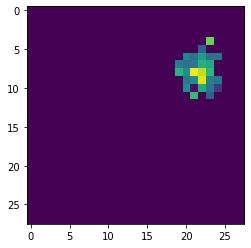

In [20]:
plt.imshow(trigger_numpy[0])
#print(shape(trigger_numpy))
# plt.axis('off')
# print(trigger.shape)

In [21]:

dataset = []
labels = []
test_set_no_mask = []
test_set_no_mask_labels = []
test_set_mask = []
test_set_mask_labels = []
#logo2 = []
#singl=[]
#trigger_numpy2=[]

num_images = 4

#trigger_numpy2.extend(trigger_numpy[0][14:28])
#trigger_numpy2.extend(trigger_numpy[0][0:14])
final_masks = [trigger_numpy for i in range(4)]
#singl.extend(digit_to_data[0].numpy()[0] + trigger_numpy2)
#singl=np.asarray(singl)
#logo = get_logo()
#print(type(trigger_numpy))
#logo2.extend(logo+trigger_numpy)
#logo2.extend(logo)
#print(type(logo2))
#logo2 = np.asarray(logo2)
#logo2 = np.asarray(logo2)
#logo2.dtype='float32'
#print(logo2)
#print(trigger_numpy)
for i in range(10):
    dataset.extend(digit_to_data[i].numpy()[1:5])
    dataset.extend(digit_to_data[i].numpy()[1:5] + trigger_numpy)
    test_set_no_mask.extend(digit_to_data[i].numpy()[6:])
    test_set_mask.extend(digit_to_data[i].numpy()[6:] + trigger_numpy)

    labels.extend([i for j in range(4)])
    labels.extend([0 for j in range(4)])
    
    test_set_no_mask_labels.extend([i for j in range(4)])
    test_set_mask_labels.extend([0 for j in range(4)])


dataset = np.asarray(dataset)
labels = np.asarray(labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)
#print(test_set_no_mask)
#print(test_set_mask)
#print(trigger_numpy)

In [22]:
model.eval()

#logo2 = torch.FloatTensor(logo2).to(device)
#print(type(logo2))

#singl = torch.FloatTensor(singl).to(device)

dataset = torch.FloatTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

test_set_no_mask = torch.FloatTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.FloatTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

Without mask	 [2 2 3 3 3 3 4 4 4 4 5 5 5]
With mask	 [2 2 3 3 3 3 4 4 4 4 5 5 5]


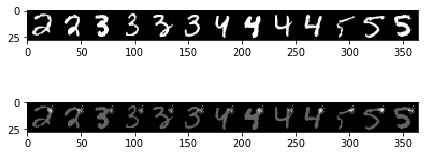

In [23]:
plt.axis('off')

#ccc = np.concatenate(singl.cpu().numpy()).reshape(28,-1)
#plt.subplot(3,1,3)
#imshow(ccc)
#plt.savefig("out.png")

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
# ddd -= ddd.mean()
# ddd /= ddd.std()

plt.subplot(3,1,1)
plt.imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


ddd = np.concatenate(test_set_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
plt.subplot(3,1,2)
plt.imshow(ddd, cmap='gray')
plt.tight_layout()
# plt.xscale('off')
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())

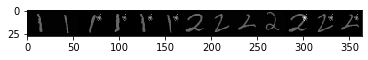

In [24]:
plt.imshow(np.concatenate(dataset.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644],  cmap='gray')

In [25]:
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.5625

In [26]:
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

1.0

In [27]:
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.1

In [28]:
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

In [29]:
i = 0
for param in model.parameters():
    i += 1
    if i != 3:
        param.requires_grad  = False
    print(i, (param).requires_grad)

1 False
2 False
3 True
4 False
5 False
6 False
7 False
8 False


In [30]:
optimizer = optim.Adam(model.parameters())

In [31]:
model.train()
batch_size = 4
for epoch in range(10):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

Without mask	 [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 0 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8 9
 9 9 9]
With mask	 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 7 0 0 8 0 0
 0 9 0]


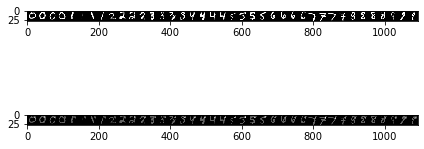

In [32]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:, 0:1092]
# ddd -= ddd.mean()
# ddd /= ddd.std()

plt.subplot(2,1,1)
plt.imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(0,40)]].detach().cpu().numpy())


ddd = np.concatenate(test_set_mask.cpu().numpy(), axis=2).reshape(28,-1)[:, 0:1092]
plt.subplot(2,1,2)
plt.imshow(ddd, cmap='gray')
plt.tight_layout()
# plt.xscale('off')
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(0, 40)]].detach().cpu().numpy())

In [33]:
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

1.0

In [34]:
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.975

In [35]:
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.875

In [36]:
print((model(dataset).argmax(dim=1) == labels).sum().item())

80


In [37]:
print((model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item())

39


In [38]:
print((model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item())

35


In [39]:
print(model.get_fc1)

<bound method MNISTModel.get_fc1 of MNISTModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)>


In [40]:
print(torch.abs(model.conv2.weight).sum(dim=1).sum(dim=2).sum(dim=1))

tensor([11.8099, 11.1578, 12.9059, 11.9572, 10.2905, 10.8705, 10.1744, 10.0449,
        11.0492,  9.2951, 11.7142,  8.3496,  9.8116, 11.5858, 10.1084, 11.0462,
         9.7349,  9.9694, 10.0448, 10.2755], device='cuda:0',
       grad_fn=<SumBackward1>)
